# Lab 8 - RNN

This is a tutorial training various RNNs on simple datasets and doing some analysis.
In acest laborator vom parcurge notiuni introductive privind retelele recurente si folosirea lor pentru a prezice valori viitoare ale unei serii (i.e. setup predictiv - de regresie).

Structura:
  1. Implementarea unei celule RNN simple
  2. Implementarea unui model folosind o celula LSTM
  3. Intelegerea conceptului de **teacher forcing** si **warm start** (in cadrul predictiei)

## Importuri

In [8]:
#@title Imports

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math
import numpy as np

import torch
import torch.nn as nn 
from torch.nn import LSTM

from matplotlib import pyplot as plt

# Task 1.    Vanilla RNN

Implementati o celula RNN de baza folosind straturi liniari din PyTorch.

   $$ h_t = f( Wx_t + Vh_{t-1}  + b) $$
   
   Unde
   
   * $x_t$ inputul la momentul $t$ de dimensiunea (batch_size, input_features)
   * $h_t$ hidden state at time $t$ de dimensiunea (batch_size, hidden_size)
   * $W$ proiectie input-to-hidden (antrenabil) 
   * $V$ proiectie hidden-to-hidden (antrenabil)
   * $b$ bias (antrenabil)
   * $f$ functia non-lineara aleasa (de regula tanh)

In [9]:
#@title Vanilla RNN

class VanillaRNN(nn.Module):
    def __init__(self, input_size=1, output_size=1, hidden_size=20, bias=False, activation=nn.Tanh):
        """
        Creates a vanilla RNN where input-to-hidden is a nn.Linear layer
        and hidden-to-output is a nn.Linear layer
        
        :param input_size: the size of the input to the RNN
        :param hidden_size: size of the hidden state of the RNN
        :param output_size: size of the output
        """
        super(VanillaRNN, self).__init__()
        
        self._input_size = input_size
        self._hidden_size = hidden_size
        self._output_size = output_size
        self._bias = bias
        self._activation = activation()
        
        self.in_to_hidden = nn.Linear(self._input_size, self._hidden_size, bias=self._bias)
        self.hidden_to_hidden = nn.Linear(self._hidden_size, self._hidden_size, bias=self._bias)
        self.hidden_to_out = nn.Linear(self._hidden_size, self._output_size, bias=self._bias)
    
    def step(self, input, hidden=None):
        ## TODO 1.1:
        ## Proiectați intrarea la dimensiunea stratului ascuns;  
        ## Obțineți vectorul ascuns actualizat - h_t = f_activare(W_ih x input + W_hh x h_{t-1})
        ## Obțineți ieșirea prin proiectarea vectorului ascuns actualizat la dimensiunea stratului de ieșire.  
        
        # Valori default de tensori 0 -- A SE INLOCUI
        # hidden_ = torch.zeros(self._hidden_size, requires_grad=True).to(device)
        # output_ = torch.zeros(self._output_size, requires_grad=True).to(device)
        if hidden is not None:
            hidden_ = self._activation(self.in_to_hidden(input) + self.hidden_to_hidden(hidden))
        else:
            hidden_=self._activation(self.in_to_hidden(input))
        output_ = self.hidden_to_out(hidden_)

        return output_, hidden_
    
    
    def forward(self, inputs, hidden=None, teacher_forcing_prob=0.5, warm_start=10):
        batch_size = inputs.size(0)
        steps = inputs.size(1)
        
        outputs = torch.autograd.Variable(torch.zeros(batch_size, steps, self._output_size)).to(device)
        
        output_ = None
        hidden_ = hidden
        
        ## TODO 1.2 - your code here: propagati secventa de antrenare prin retea
        ## Nota: 
        ##    inputs - tensor de forma (batch_size, seq_len, 1)
        ##    self.step primeste intrare de forma input: (batch_size, 1), hidden: (batch_size, hidden_size)
        ##    self.step intoarche iesire de forma output: (batch_size, 1), hidden: (batch_size, hidden_size)
        for i in range(steps):
            # Definiti forma lui input_ de trimis catre self.step() 
            # Valoare default = tensor cu valori de 0 - A SE INLOCUI
            # input_ = torch.zeros(batch_size, self._input_size).to(device)

            # Dacă este primul pas (i=0), există o perioadă de warm_start (context)  
            # în timpul testării sau se aplică teacher forcing, 
            # atunci următoarea input_ ar trebui selectată din valorile reale (ground truth).  
            # În caz contrar, input_ ar trebui să fie ceea ce rețeaua a returnat  
            # la pasul anterior de timp. 
            # input_ = ...

            if i==0 or i<warm_start or (torch.rand(1).item() < teacher_forcing_prob):
                input_ = inputs[:, i, :]
            else:
                input_ = output_ 

            # calculam un pas de recurenta
            output_, hidden_ = self.step(input_, hidden_)
            
            # scriem iesirea output_ de forma (batch_size, 1) la indexul i (pe dimensiunea de lungime a secventei)
            # in tensorul de iesire outputs
            outputs[:, i, :] = output_
        
        return outputs, hidden_
        

# Task 2.    RNN simplu folosind un modul LSTM

In [10]:
class LSTMRNN(nn.Module):
    def __init__(self, input_size=1, output_size=1, hidden_size=20, bias=False, batch_first = True, num_layers = 1):
        super(LSTMRNN, self).__init__()
        self._input_size = input_size
        self._hidden_size = hidden_size
        self._output_size = output_size
        self._bias = bias
        
        self.rnn = LSTM(input_size = input_size, 
                        proj_size = output_size, 
                        hidden_size = hidden_size, 
                        bias=bias,
                        num_layers = num_layers, 
                        batch_first = batch_first)
        
        
    def forward(self, inputs, hidden=None, teacher_forcing_prob=0.5, warm_start=10):
        batch_size = inputs.size(0)
        steps = inputs.size(1)

        outputs = torch.autograd.Variable(torch.zeros(batch_size, steps, self._output_size)).to(device)
        
        output_ = torch.zeros(batch_size, 1, self._output_size).to(device)
        hidden_ = None

        for i in range(steps):
            ## TODO 2.1: propagati secventa de antrenare prin retea
            ## Nota: 
            ##    inputs - tensor de forma (batch_size, seq_len, 1)
            ##    self.rnn primeste intrare de forma 
            ##      input_: (batch_size, seq_len=1, input_size=1), 
            ##      hidden_: tuplu de (hidden_state, cell_state) de dim. (num_layers, batch_size, hidden_size)
            ##    self.rnn intoarche iesire de forma output: (batch_size, seq_len=1, output_size=1)
            
            # Definiti forma lui input_ de trimis catre self.step() 
            # Valoare default = tensor cu valori de 0 - A SE INLOCUI
            # input_ = torch.zeros(batch_size, 1, self._input_size).to(device)
            
            # Dacă este primul pas (i=0), există o perioadă de warm_start (context)  
            # în timpul testării sau se aplică teacher forcing, 
            # atunci următoarea input_ ar trebui selectată din valorile reale (ground truth).  
            # În caz contrar, input_ ar trebui să fie ceea ce rețeaua a returnat  
            # la pasul anterior de timp. 
            ## input_ = ...
            if i==0 or i<warm_start or (torch.rand(1).item() < teacher_forcing_prob):
                input_ = inputs[:, i, :].unsqueeze(1)
            else:
                input_ = output_ 
                
            ## end code
            output_, hidden_ = self.rnn(input_, hidden_)
            outputs[:, i, :] = output_.squeeze(1)
        
        return outputs, hidden_

# Antrenarea retelei RNN pentru a prezice o curba sinusoidala

Antrenam reteaua pe o curba sinusoidala - predictia urmatoarei valori din sinusoida pe baza valorilor *prezise* anterior.

Predictie pentru   $$ sin (x +t \epsilon) $$ from $$ sin (x), sin (x + \epsilon), ..., sin (x + (t-1) \epsilon) $$

În special, dorim ca rețeaua să prezică următoarea valoare într-o buclă, condiționând predicția de unele valori inițiale (furnizate) și de toate predicțiile ulterioare.

Pentru a învăța modelul de predicție, vom folosi **teacher forcing**. Aceasta înseamnă că atunci când antrenam modelul, intrarea la momentul $t$ este secvența reală la momentul $t$, mai degrabă decât rezultatul produs de model la $t-1$. 

**Când dorim să generăm** date din model, **nu avem acces la succesiunea adevărată**, așa că nu folosim *teacher forcing*. 
Totuși, în cazul problemei noastre, vom folosi notiunea de **warm start (pornire la cald)**, deoarece avem nevoie de mai mulți pași de timp pentru a prezice următoarea valoare a undei sinusoidale (cel puțin 2, pentru valoarea inițială și pentru pas).

Codul de mai jos derulează modelul RNN pe care l-ați definit mai sus, face antrenamentul folosind backprop în timp (BPTT) și trasează datele reale ("ground truth"), datele generate în timpul antrenamentului ("training predictions") și eșantioanele de model "generate".

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Running code @ {device}')

Running code @ cpu


In [12]:
UNROLL_LENGTH = 20  #@param {type:"integer"}
NUM_ITERATIONS = 10000  #@param {type:"integer"}
WARM_START = 10  #@param {type:"integer"}
TEACHER_FORCING_PROB = 1.0  #@param {type:"slider", min:0.0, max:1.0, step:0.25}
HIDDEN_UNITS = 20  #@param {type:"integer"}
LEARNING_RATE = 0.001  #@param {type:"number"}
REPORTING_INTERVAL = 200  #@param {type:"integer"}
BATCH_SIZE = 3 #@param {type:"integer"}

# We create training data, sine wave over [0, 2pi]
x_train = np.arange(0, 2*np.pi, 0.1).reshape(-1, 1)
y_train = np.sin(x_train)



In [13]:
def create_batch(y_train, unroll_length, batch_size):
    y_batch = np.zeros((batch_size, unroll_length, 1))
    starts = np.zeros(batch_size, dtype=np.int64)
    
    for i in range(batch_size):
        start = np.random.choice(range(y_train.shape[0] - UNROLL_LENGTH))
        train_sequence = y_train[start : (start + UNROLL_LENGTH)]
        
        starts[i] = start
        y_batch[i, :, :] = train_sequence
        
    return y_batch, starts

[200] avg_loss: 0.31295, report_loss: 0.21520, 


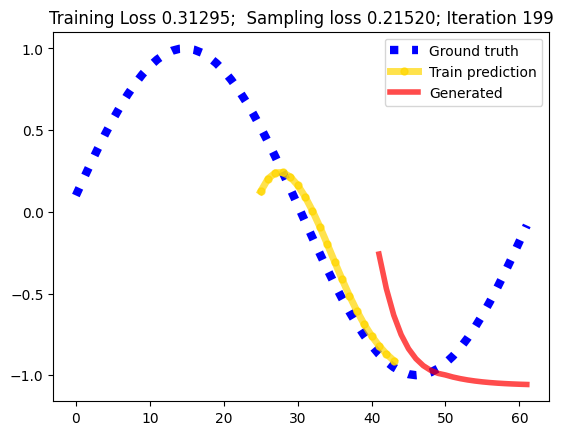

[400] avg_loss: 0.04634, report_loss: 0.46274, 


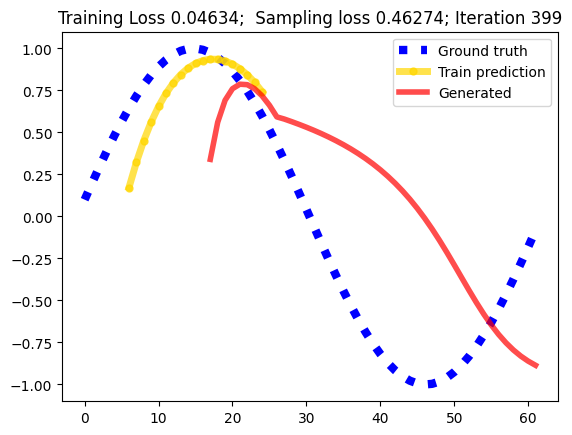

[600] avg_loss: 0.02585, report_loss: 0.11063, 


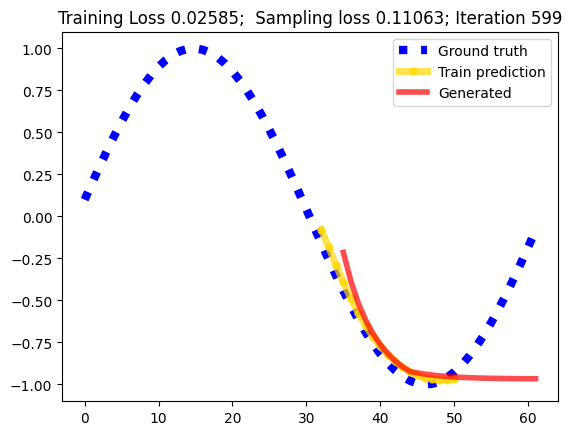

[800] avg_loss: 0.01629, report_loss: 0.08620, 


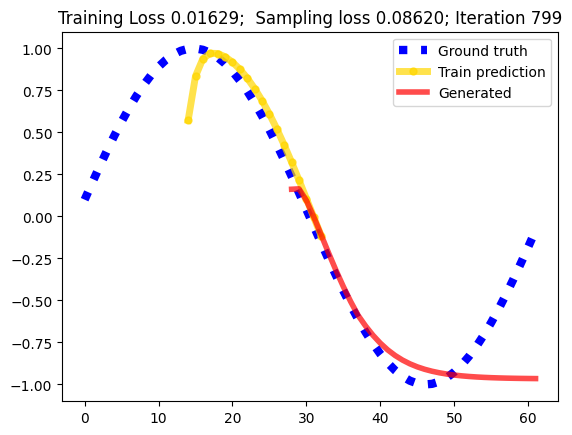

[1000] avg_loss: 0.00998, report_loss: 0.12501, 


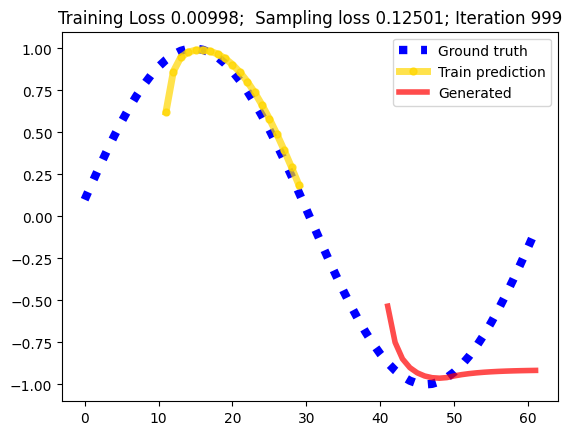

[1200] avg_loss: 0.00630, report_loss: 0.07900, 


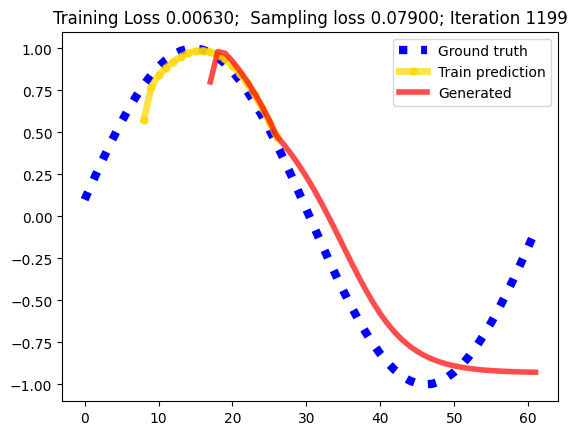

[1400] avg_loss: 0.00419, report_loss: 0.10177, 


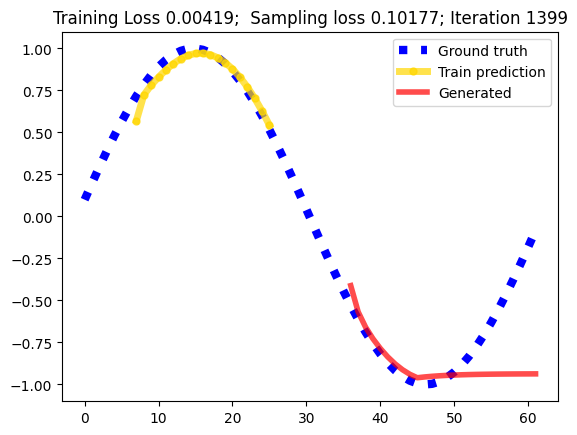

[1600] avg_loss: 0.00303, report_loss: 0.06489, 


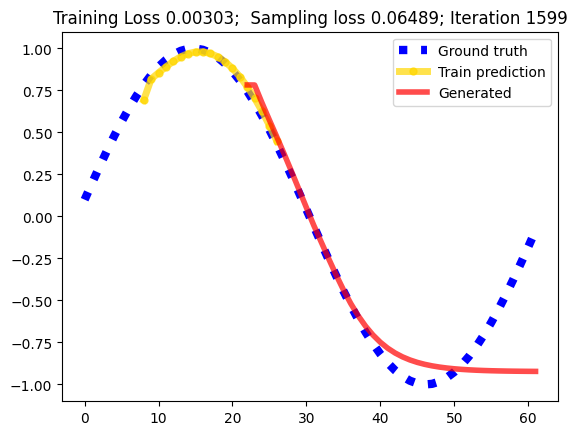

[1800] avg_loss: 0.00221, report_loss: 0.04843, 


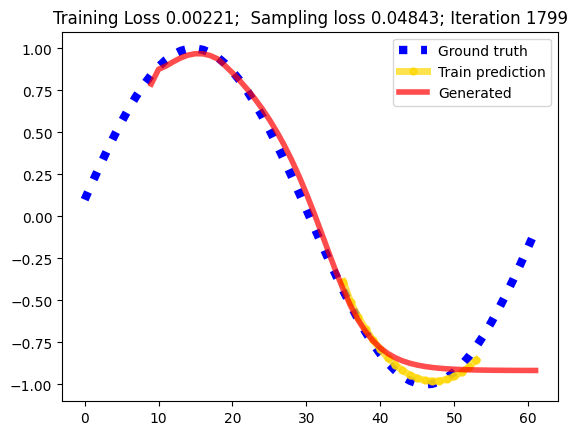

[2000] avg_loss: 0.00199, report_loss: 0.05298, 


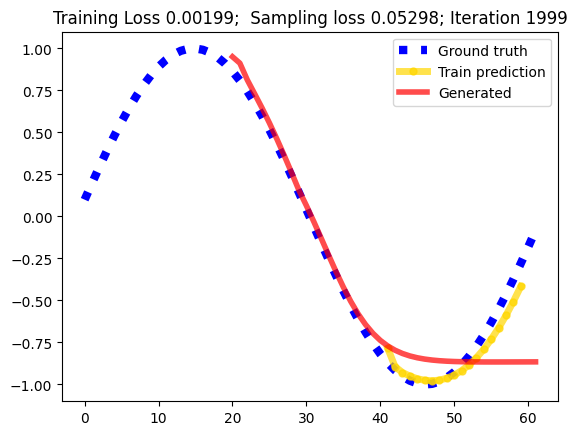

[2200] avg_loss: 0.00191, report_loss: 0.08545, 


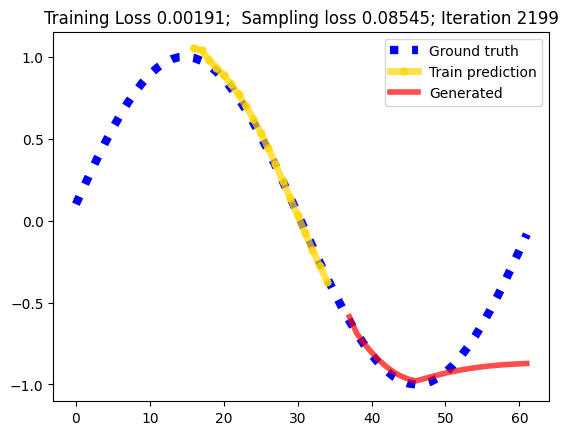

[2400] avg_loss: 0.00168, report_loss: 0.08699, 


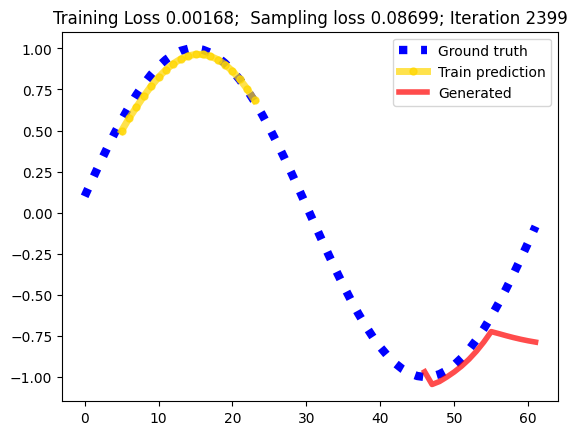

[2600] avg_loss: 0.00145, report_loss: 0.06201, 


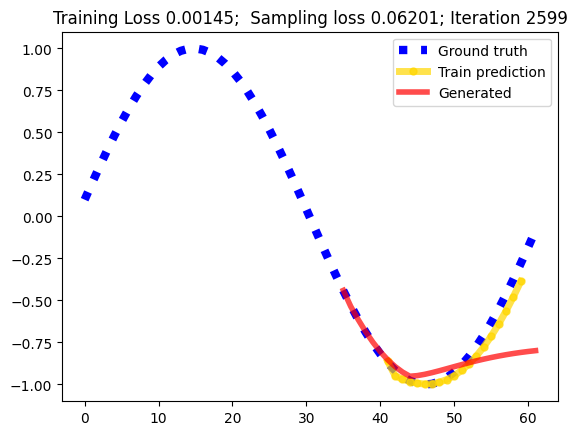

[2800] avg_loss: 0.00147, report_loss: 0.03505, 


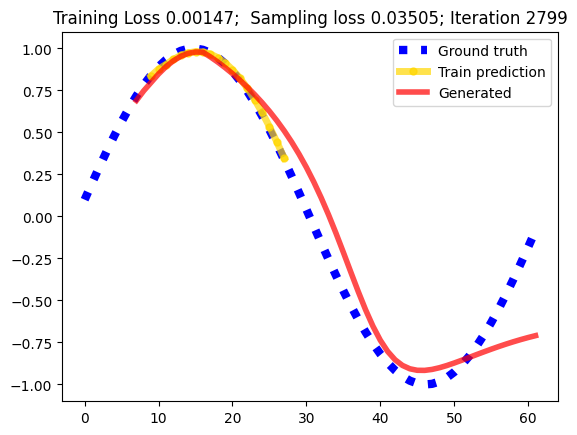

[3000] avg_loss: 0.00131, report_loss: 0.03334, 


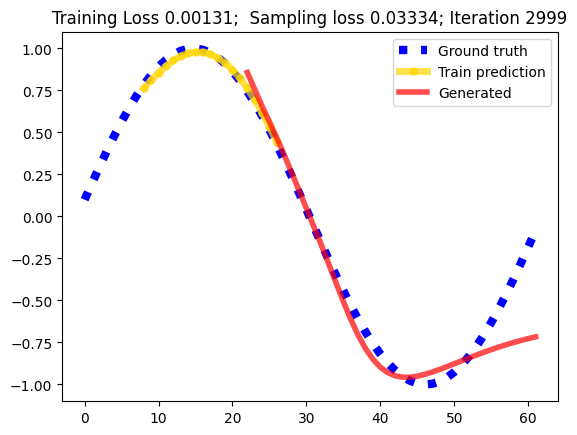

[3200] avg_loss: 0.00121, report_loss: 0.07849, 


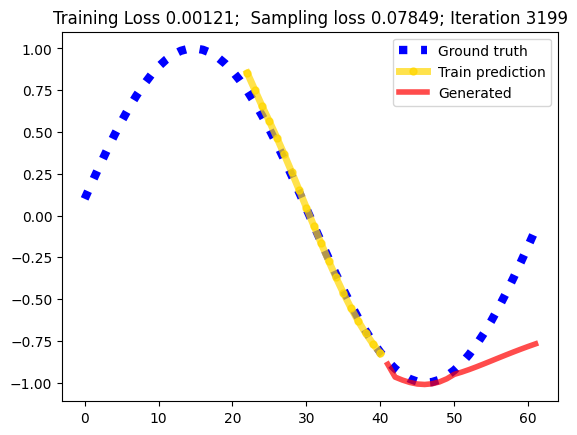

[3400] avg_loss: 0.00120, report_loss: 0.03020, 


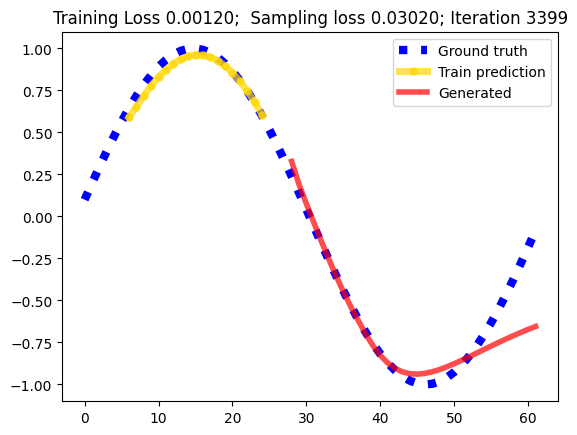

[3600] avg_loss: 0.00121, report_loss: 0.02776, 


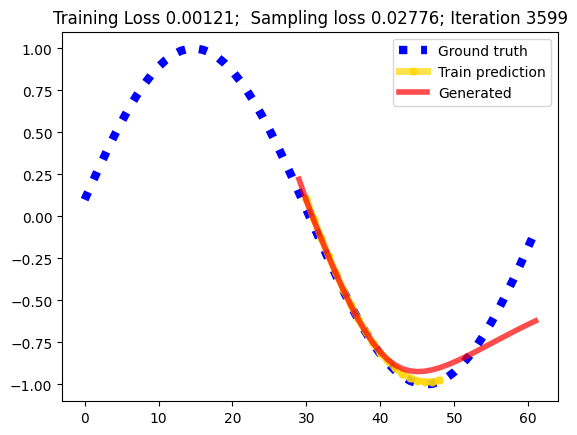

[3800] avg_loss: 0.00113, report_loss: 0.03036, 


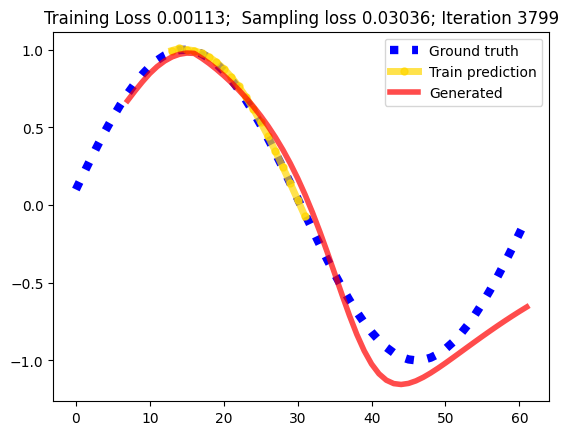

[4000] avg_loss: 0.00108, report_loss: 0.02580, 


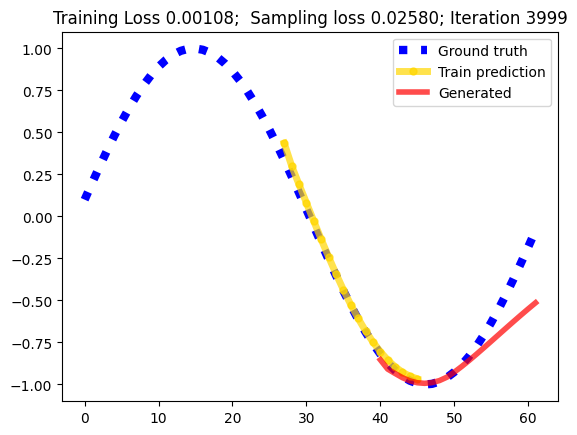

[4200] avg_loss: 0.00110, report_loss: 0.02246, 


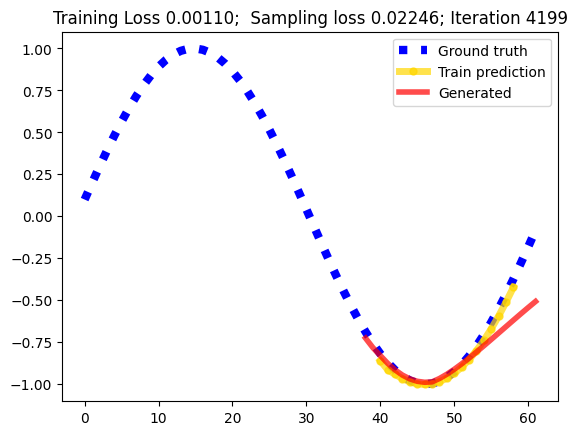

[4400] avg_loss: 0.00105, report_loss: 0.02293, 


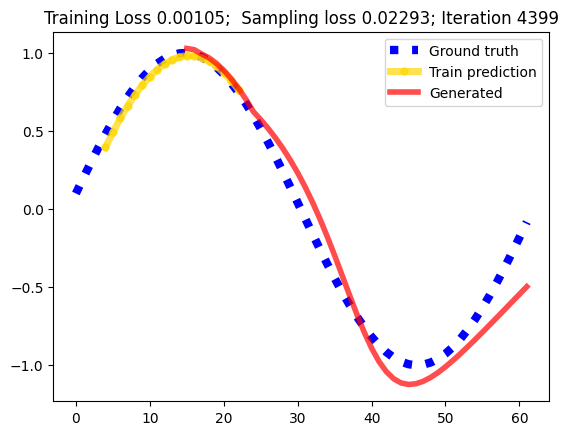

[4600] avg_loss: 0.00095, report_loss: 0.01353, 


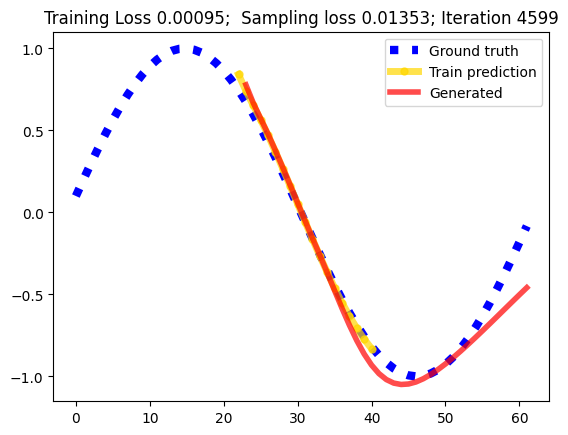

[4800] avg_loss: 0.00100, report_loss: 0.06369, 


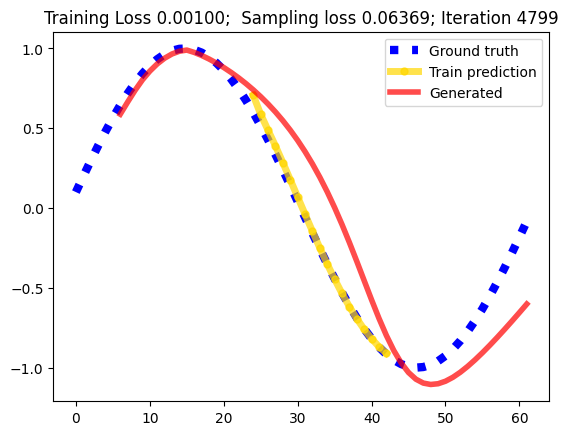

[5000] avg_loss: 0.00096, report_loss: 0.05923, 


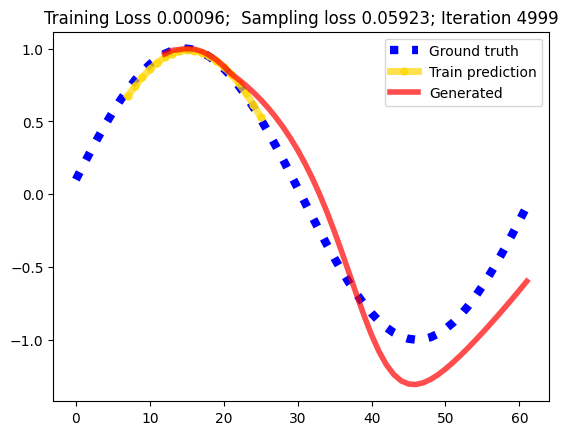

[5200] avg_loss: 0.00097, report_loss: 0.02369, 


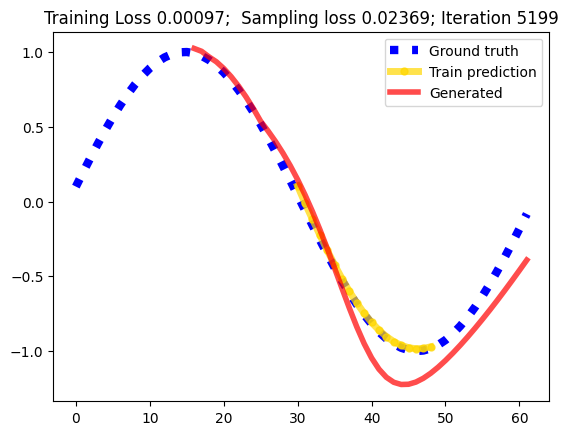

[5400] avg_loss: 0.00097, report_loss: 0.00813, 


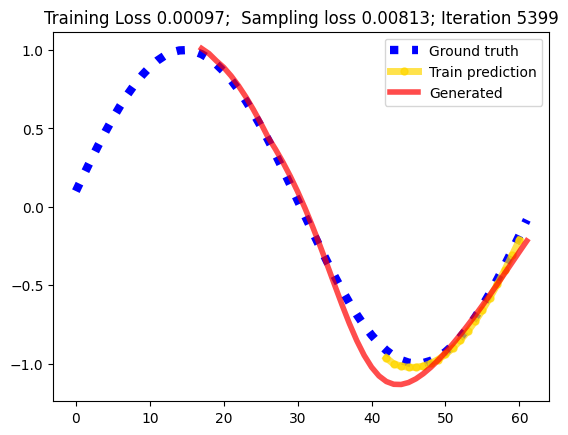

[5600] avg_loss: 0.00089, report_loss: 0.00688, 


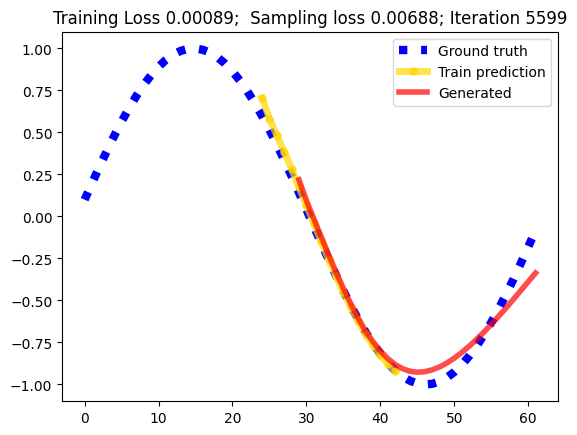

[5800] avg_loss: 0.00088, report_loss: 0.02499, 


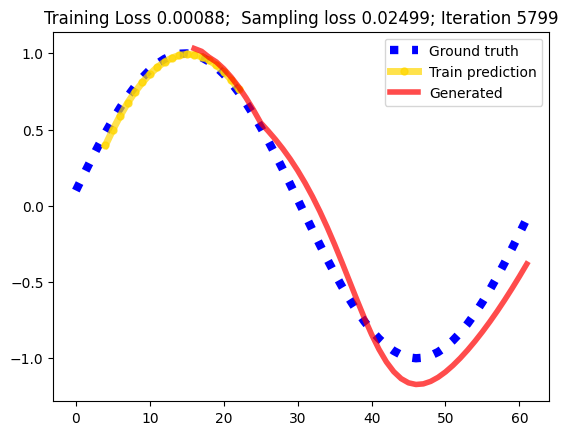

[6000] avg_loss: 0.00091, report_loss: 0.00723, 


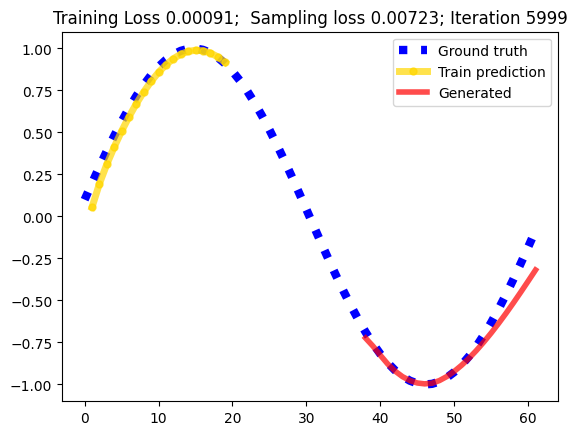

[6200] avg_loss: 0.00077, report_loss: 0.03069, 


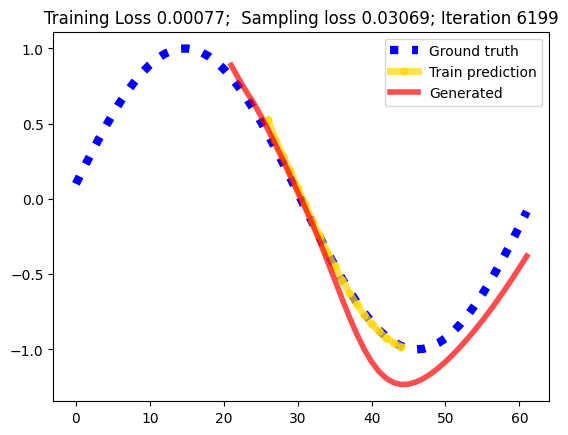

[6400] avg_loss: 0.00084, report_loss: 0.01239, 


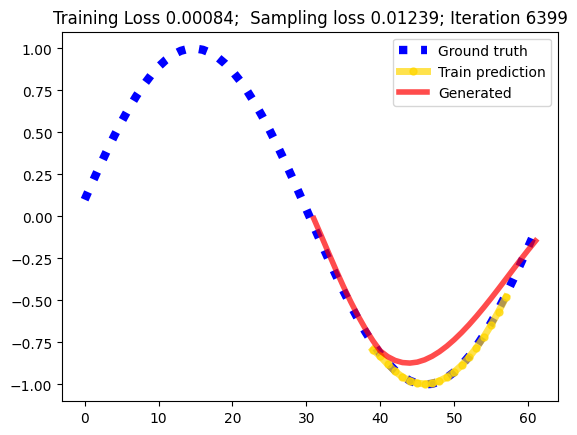

[6600] avg_loss: 0.00082, report_loss: 0.01091, 


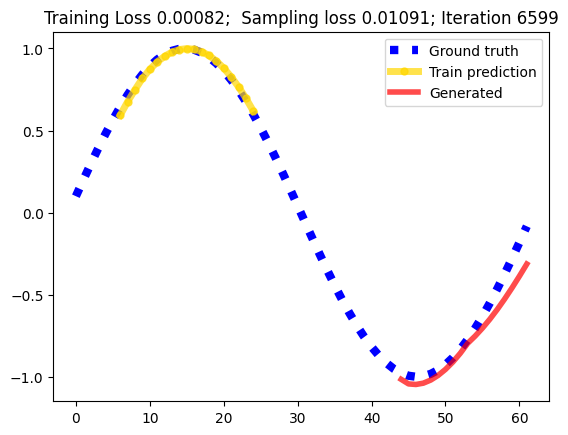

[6800] avg_loss: 0.00082, report_loss: 0.01972, 


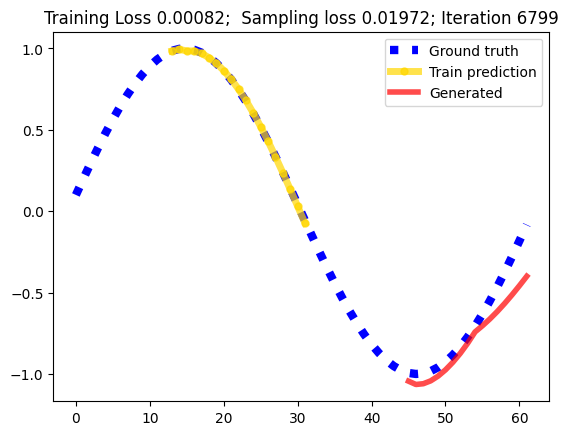

[7000] avg_loss: 0.00076, report_loss: 0.06305, 


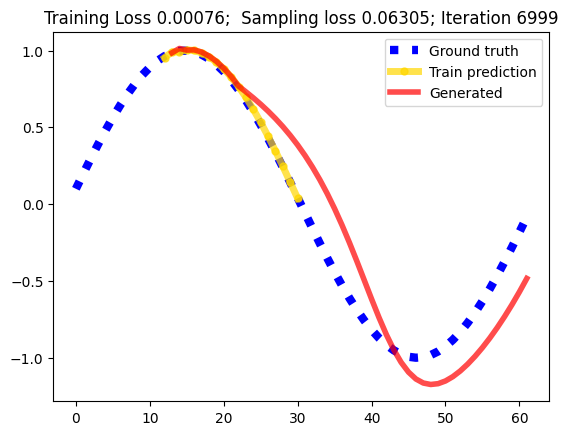

[7200] avg_loss: 0.00070, report_loss: 0.00484, 


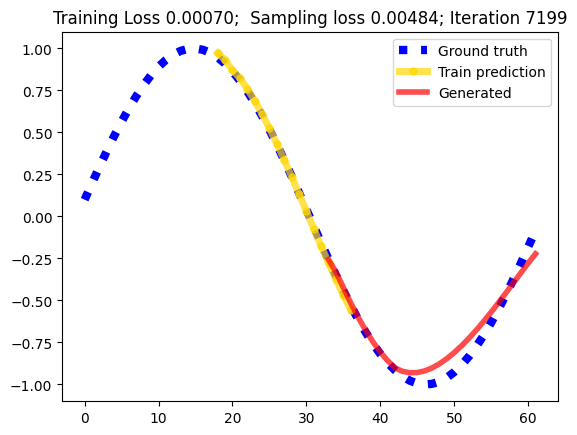

[7400] avg_loss: 0.00067, report_loss: 0.02639, 


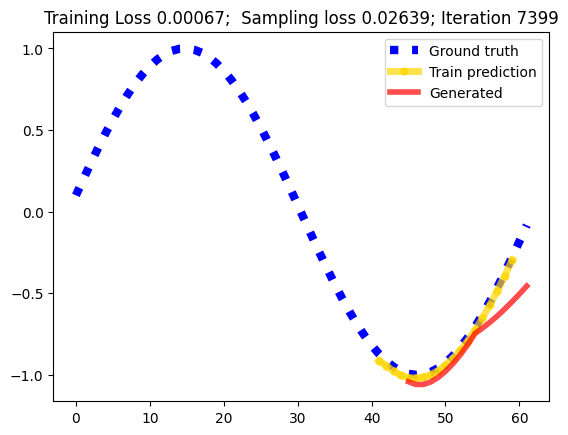

[7600] avg_loss: 0.00067, report_loss: 0.00777, 


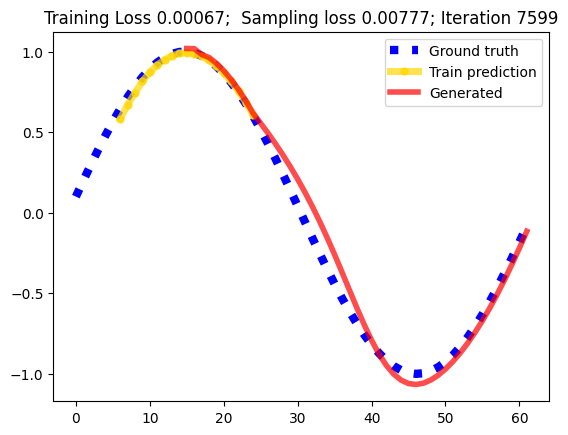

[7800] avg_loss: 0.00065, report_loss: 0.02305, 


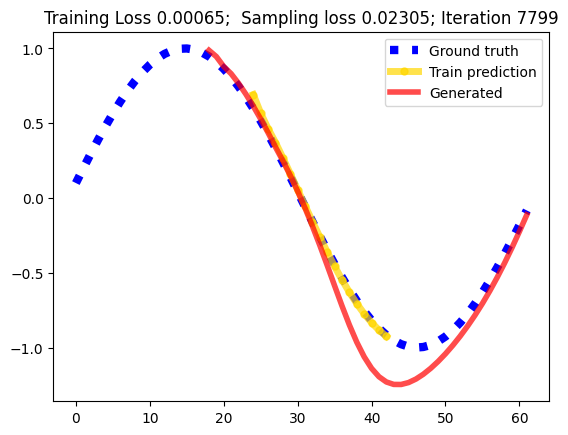

[8000] avg_loss: 0.00057, report_loss: 0.00350, 


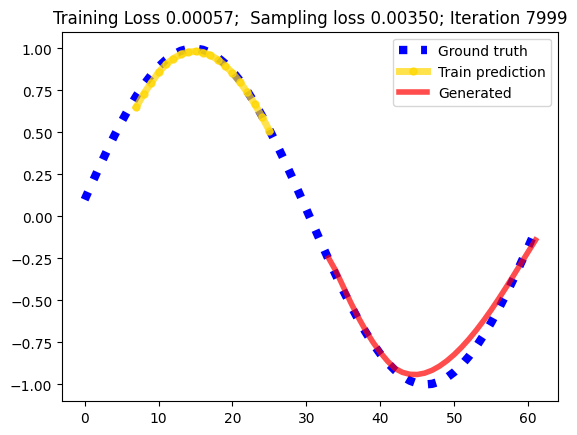

[8200] avg_loss: 0.00060, report_loss: 0.00865, 


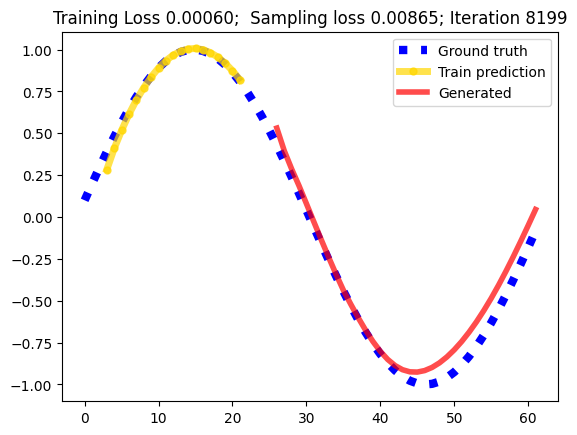

[8400] avg_loss: 0.00055, report_loss: 0.00225, 


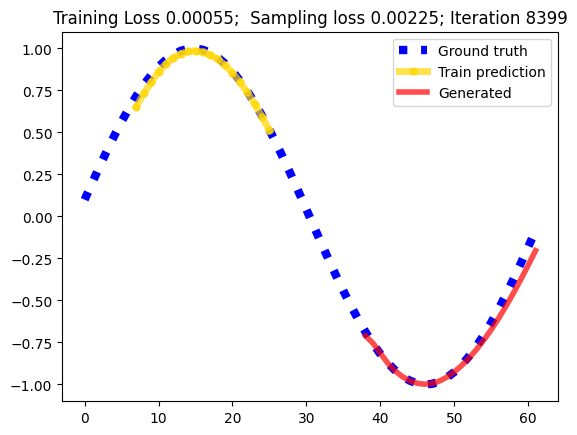

[8600] avg_loss: 0.00056, report_loss: 0.00417, 


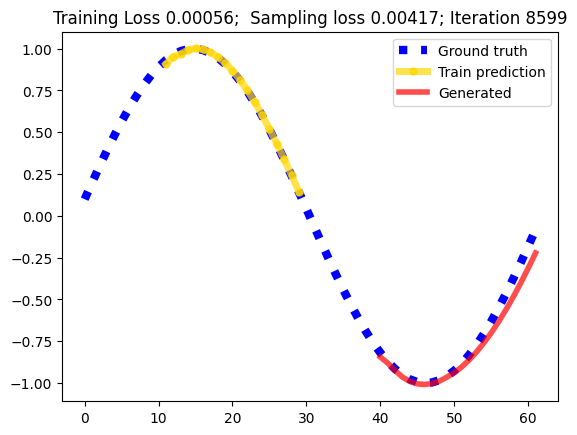

[8800] avg_loss: 0.00056, report_loss: 0.00283, 


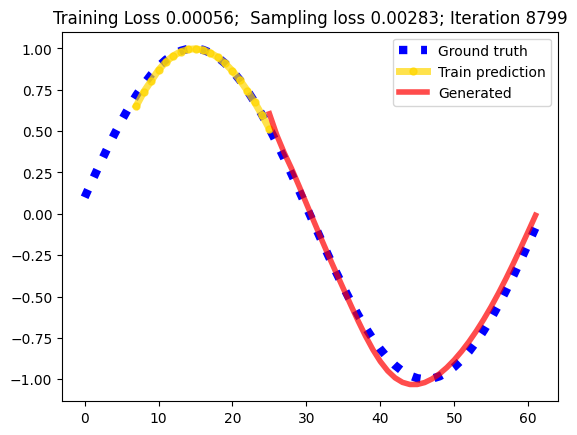

[9000] avg_loss: 0.00054, report_loss: 0.01451, 


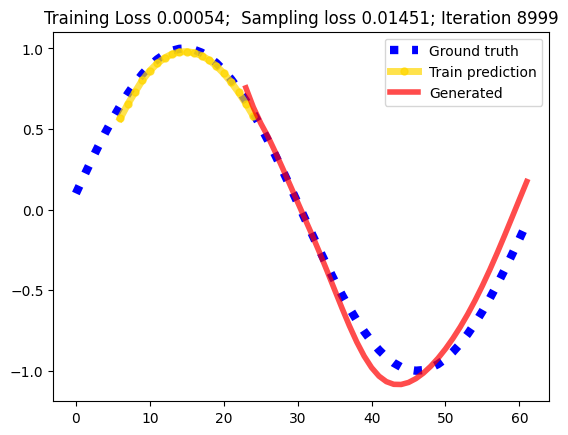

[9200] avg_loss: 0.00056, report_loss: 0.00415, 


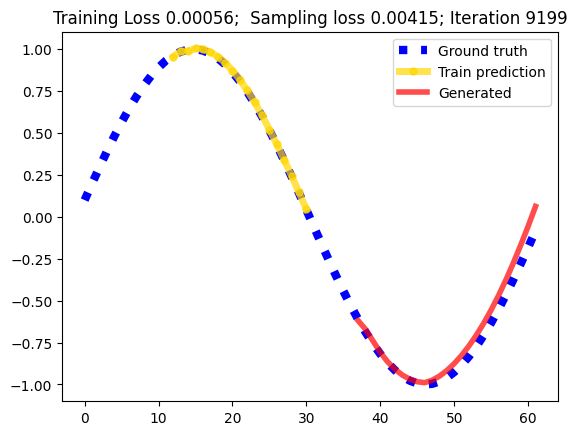

[9400] avg_loss: 0.00050, report_loss: 0.01492, 


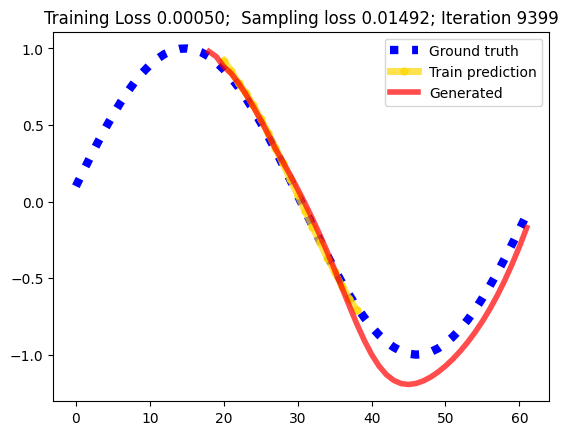

[9600] avg_loss: 0.00051, report_loss: 0.01141, 


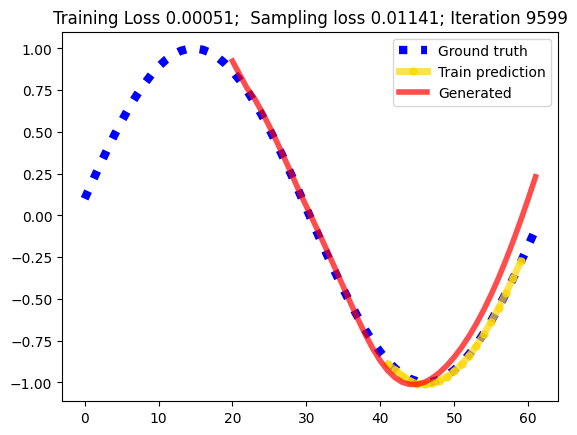

[9800] avg_loss: 0.00050, report_loss: 0.04212, 


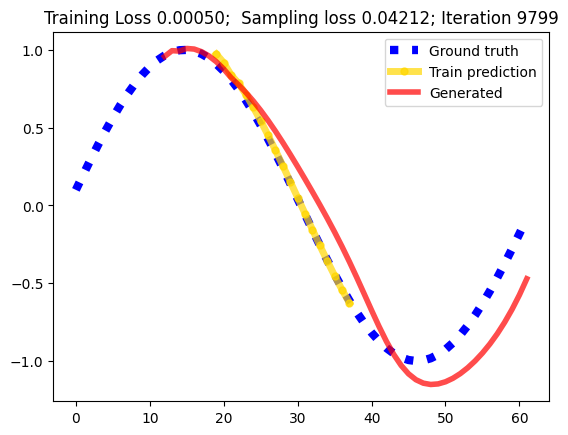

[10000] avg_loss: 0.00051, report_loss: 0.01980, 


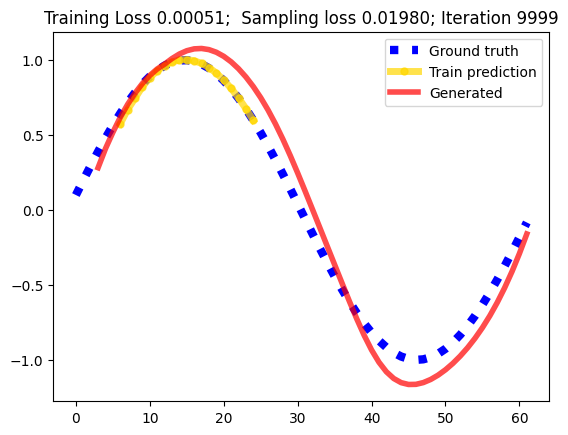

In [14]:
# net = VanillaRNN(hidden_size=HIDDEN_UNITS, bias=True)
net = LSTMRNN(hidden_size=HIDDEN_UNITS, bias=True, num_layers = 1)
net = net.to(device)
net.train()

criterion = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

running_loss = 0

for iteration in range(NUM_ITERATIONS):
    # select a start point in the training set for a sequence of UNROLL_LENGTH
    train_batch, starts = create_batch(y_train, UNROLL_LENGTH, BATCH_SIZE)
    
    train_inputs = torch.from_numpy(train_batch[:,:-1,:]).float().view(BATCH_SIZE, UNROLL_LENGTH-1, 1).to(device)
    train_targets = torch.from_numpy(train_batch[:,1:, :]).float().view(BATCH_SIZE, UNROLL_LENGTH-1, 1).to(device)
    
    optimizer.zero_grad()
    
    outputs, hidden = net(train_inputs, 
                          hidden=None, 
                          teacher_forcing_prob=TEACHER_FORCING_PROB, 
                          warm_start=0)
    
    loss = criterion(outputs, train_targets)
    loss.backward()
    
    running_loss += loss.item()
    
    optimizer.step()
    
    if iteration % REPORTING_INTERVAL == REPORTING_INTERVAL - 1:
        # let's see how well we do on predictions for the whole sequence
        avg_loss = running_loss / REPORTING_INTERVAL
        running_loss = 0.0
        
        # Select a start point within the first 75% of y_train
        max_start_index = int(0.75 * len(y_train))
        report_start_index = np.random.choice(range(max_start_index))
        
        # Create the reporting sequence
        report_sequence = torch.from_numpy(y_train[report_start_index:-1]).float().unsqueeze(0).to(device)
        report_targets = torch.from_numpy(y_train[report_start_index + 1:]).float().unsqueeze(0).to(device)
        
        net.eval()
        report_output, report_hidden = net(report_sequence, hidden=None, 
                                           teacher_forcing_prob=0.0, 
                                           warm_start=WARM_START)
        
        report_loss = criterion(report_output, report_targets)
        print('[%d] avg_loss: %.5f, report_loss: %.5f, ' % (iteration + 1, avg_loss, report_loss.item()))
        # print(outputs[0, :, :].detach().data.cpu().numpy().ravel())
        
        plt.figure()
        plt.title('Training Loss %.5f;  Sampling loss %.5f; Iteration %d' % (avg_loss, report_loss.item(), iteration))
        
        plt.plot(y_train[1:].ravel(), c='blue', label='Ground truth',
               linestyle=":", lw=6)
        plt.plot(range(starts[0], starts[0]+UNROLL_LENGTH-1), 
                 outputs[0, :, :].detach().data.cpu().numpy().ravel(), 
                 c='gold', label='Train prediction', lw=5, marker="o", markersize=5, alpha=0.7)
        plt.plot(range(report_start_index, len(y_train)-1), 
                 report_output.detach().data.cpu().numpy().ravel(), 
                 c='r', label='Generated', lw=4, alpha=0.7)
        plt.legend()
        plt.show()
        
        net.train()

# TASK 3: Evaluarea influentei hiper-parametrilor

Testati pe baza codului de mai sus urmatoarele configuratii:
  * BATCH_SIZE: 1, 16 (default), 32
  * UNROLL_LENGTH: 6, 30 (default), 62
  * TEACHER_FORCING: 0.25 (default), 1.0
  
Raspundeti la urmatoarele intrebari:
  1. Care este influenta TEACHER_FORCING-ului? In ce situatii ar trebui evitat / redus?
  2. Care este influenta UNROLL_LENGTH-ului (lungimea secventei de antrenare)? Ce se poate intampla daca UNROLL_LENGTH este foarte mic?